# Passage cadCAD Experimentation

This is the notebook we will use to test different config files and visualize different simulations for the indexing task specifically.

# Questions to Answer

1. how much is it going to cost to run the indexer software? fixed costs, per query costs
2. what's the query pricing model? needs to be worth it for indexers to make the investment in the maintenance software (query demand needs to be high enough)
3. is there a initiation fee to start indexing? 
4. how would payouts to the different participants affect indexer profitability? 
5. how many queries would someone have to serve in order to enter profitability? 
6. can query cost be dynamic?

WHEN DOES AN INDEXER GET PROFITABLE?
- timestep is query count
- we want to know at what point does indexing break even and become profitable?
- cross of cost + profit lines

# Variables

- Total Fee (initial number to send through sim)
- Indexer Cost to Serve (% of total fee)
- External Data Source Cost (% of total fee)
- Delegator (% of total fee)
- Membership (% of total fee)
- Indexer Profit (% of total fee)

# States

- Indexer Balance
  - starting this at a negative value can denote fixed server cost

we're modeling the query count and query fee

# Fresh Go

We've got the indexer balance that we're trying to update. The indexer balance is influenced by a number of variables. The initial state of the indexer balance is the Total Fee. Then the total fee is dispersed amongst the various stakeholders and the values that those stakeholders get is chosen via randomly sampling from numerical ranges (reasonable sets of values for those fee %s). 


# Dependencies

In [ ]:
!pip install cadCAD matplotlib pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 1.7 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 52 kB 697 kB/s 
     |████████████████████████████████| 115 kB 11.6 MB/s 
  Created wheel for fn: filename=fn-0.4.3-py3-none-any.whl size=28239 sha256=c54ef3a8d32f013671ec2d04921e5d9034520fd2e9f3f155d56f24746493651a
  Stored in directory: /root/.cache/pip/wheels/5c/a0/65/41f733d04386c57826c2cf9e1927d716e90a46689712c9af6b
Successfully built fn


In [ ]:
# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import random as rand
import matplotlib.pyplot as plt
from pprint import pprint


# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor,ExecutionMode
from cadCAD import configs

# Definitions

### State Update and Policy Functions

In [ ]:
def p_get_data(params, substep, state_history, previous_state):
  '''
  Args:
    params (dict): python dict containing system params
    substep (int): integer value representing step within a timestep
    state_history (list): python list of all previous states
    previous_state (dict): python dict that defines what the state of the system
     was at the previous timestep or substep
  Returns:
    dict: key as signal name, value as any python type
  '''
  # assign all the system variables
  total_fee = params['total_fee']
  indexer_serve_cost = params['indexer_serve_cost']
  external_data_source_cost = params['external_data_source_cost']
  delegator_cut = params['delegator_cut']
  membership_cut = params['membership_cut']

  # compute how much of the total fee gets left over
  total_fee -= indexer_serve_cost   # subtract indexer cost to serve
  total_fee -= external_data_source_cost   # subtract cost to query external data source
  total_fee = total_fee - (total_fee * delegator_cut)  # subtract delegator %
  total_fee = total_fee - (total_fee * membership_cut)  # subtract membership %

  return({'add_to_bal': total_fee})
               


def s_indexer_balance(params, substep, state_history, previous_state, policy_input):
  '''
  Args:
    Same as policy function as well as...
    policy_input (dict): python dict of signals or actions from Policy function
  '''
  # update the indexer balance state variable
  indexer_bal_current = previous_state['indexer_balance']
  indexer_bal_change = policy_input['add_to_bal']

  indexer_bal_new = indexer_bal_current + indexer_bal_change

  return('indexer_balance', indexer_bal_new)

### Initial conditions and parameters


In [ ]:
initial_state = {
    'indexer_balance': -20,   # negative to represent up-front cost for indexer
}

# will need this if we start sampling from distributions
# seeds = {
#     'z': np.random.RandomState(1)
# }

system_parameters = {
    'total_fee': 5,
    'indexer_serve_cost': 1,   # FIXED: indexer cost to serve
    'external_data_source_cost': 1,   # FIXED: cost for querying data services
    'delegator_cut': 0.2,   # FIXED: pct of remaning fee going to delegator
    'membership_cut': 0.2,   # FIXED: pct of remaining fee going to membership
}

simulation_parameters = {
    'N': 1,
    'T': range(100),
    'M': system_parameters
}

partial_state_update_blocks = [
    { 
        'policies': {
            'p_get_data': p_get_data
        },
        'variables': {
            'indexer_balance': s_indexer_balance,
        }
    }
]

In [ ]:
experiment = Experiment()

experiment.append_configs(
    sim_configs=simulation_parameters,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()
df = pd.DataFrame(system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 5, 1, 1)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 5, 1, 1)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.03s


In [ ]:
df

,indexer_balance,simulation,subset,run,substep,timestep
0,-20.00,0,0,1,0,0
1,-18.08,0,0,1,1,1
2,-16.16,0,0,1,1,2
3,-14.24,0,0,1,1,3
4,-12.32,0,0,1,1,4
...,...,...,...,...,...,...
96,164.32,0,0,1,1,96
97,166.24,0,0,1,1,97
98,168.16,0,0,1,1,98
99,170.08,0,0,1,1,99


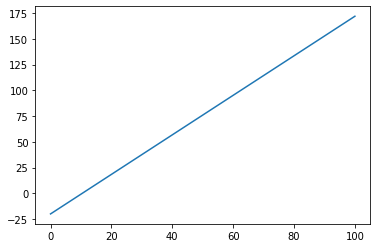

In [ ]:
plt.plot(df['timestep'], df['indexer_balance'])